In [17]:
import numpy as np
import matplotlib.pyplot as plt

class idns:
    def __init__(self, signal, nsec, sampling_freq, overlap, confidence):
        """        
        Input class idns:
        signal [numpy array] -- Signal to analyze
        nsec [float] -- Window length used for the analysis [s]
        sampling_freq [float] -- Sampling frequency [Hz]
        overlap [float] -- Overlap between windows [0-1]
        confidence [int] -- Confidence [90-95-98-99] [%]
        Return:
        idns.calc() -- Calculation
        idns.get_base() -- Get informations about statistics of entire signal
        idns.get_run() -- Get informations about run
        idns.get_limits() -- Get limits of stationary
        idns.get_bns() -- Get outcome of the test
        idns.get_index() -- Get the index of non-stationary
        idns.get_plot() -- Get the plot of the results
        
        """
        self.signal = signal
        self.nsec = nsec
        self.sampling_freq = sampling_freq
        self.overlap = overlap
        self.confidence = confidence
        
        if self.nsec < 2/self.sampling_freq:
            print('Error: nsec should be at least twice the inverse of sampling frequency')
            return None
        
    def calc(self):
        self.N_pts = len(self.signal)
        self.dt = 1/self.sampling_freq            
        self.T = self.N_pts * self.dt - self.dt             
        self.time = np.linspace(0, self.T, self.N_pts)
        self.ent_std = np.std(self.signal, ddof = 1) 
        self.ent_mean = np.mean(self.signal)        
        coeff = [1.645, 1.96, 2.326, 2.576]
        conf = [90, 95, 98, 99]
        self.alpha = coeff[conf.index(self.confidence)]
        self.data_base = {'N_pts':self.N_pts,
                          'time':self.time,
                          'std':self.ent_std,
                          'mean':self.ent_mean,
                          'alpha':self.alpha}
        
        wdw_pts = int(np.floor(self.sampling_freq * self.nsec)) 
        seg_pts = wdw_pts - int(np.floor(wdw_pts * self.overlap)) 
        seg = int(np.ceil(self.N_pts / seg_pts))                  
        self.seg_time = np.linspace(0,self.T,seg)
        res = self.N_pts % seg_pts      
        cls = np.array([self.signal[i:i + seg_pts] for i in range(0, self.N_pts-res, seg_pts)])

        self.seg_std = np.std(cls, axis=1, ddof=1)

        if res != 0:
            seg_res = signal[self.N_pts - res:self.N_pts]
            if len(seg_res) != 1:
                seg_res_std = np.std(seg_res,ddof=1)
                self.seg_std = np.append(self.seg_std,seg_res_std)
    
        cls_std = np.std(self.seg_std, ddof = 1)
    
        self.boundUP = self.ent_std + cls_std
        self.boundDW = self.ent_std - cls_std
                
        rn = np.empty(seg)
        for i in range(0, seg):
            if self.seg_std[i] > self.boundUP or self.seg_std[i] < self.boundDW:
                rn[i] = 1
            else:
                rn[i] = 0

        N1 = N0 = 0
        for i in range(0, seg):
            if rn[i] == 1.:
                N1 += 1
            else:
                N0 += 1
        
        N = N1 + N0
        self.Nr = 0

        for i in range(1, seg):
            if rn[i] != rn[i-1]:
                self.Nr += 1
        
        ## Stationary limits 
        if N == 0 or N == 1:
            print('Error: check window length')
            return None 
        
        self.run_mean = (2 * N1 * N0) / N + 1
        self.run_var = (2 * N1 * N0 * (2 * N1 * N0 - N)) / (N**2 * (N - 1))
        
        self.run = {'run': self.Nr, 'run_mean': self.run_mean, 'run_var': self.run_var}
        
        self.lim_up = self.run_mean + self.alpha * np.sqrt(self.run_var)
        self.lim_dw = self.run_mean - self.alpha * np.sqrt(self.run_var)

        self.index_up = np.round(100 * self.lim_up / self.run_mean, 2)
        self.index_dw = np.round(100 * self.lim_dw / self.run_mean, 2)
        
        if self.Nr >= self.lim_dw and self.Nr <= self.lim_up:   
            self.bns = 'Stationary'
        else:
            self.bns = 'Non-stationary' 
            
        self.index = np.round( 100 * self.Nr / self.run_mean, 2)
        
    
    def get_base(self):
        return self.data_base
        
    def get_run(self):        
        return self.run
        
    def get_limits(self):
        return [self.index_dw, self.index_up]

    def get_bns(self):
        return self.bns
    
    def get_index(self):
        return self.index
    
    def get_plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.time, self.signal, color = 'darkgray', zorder = 1, label = 'Signal')
        ax.plot(self.seg_time, self.ent_mean + self.seg_std, color = 'C0', zorder = 2, label = 'Segments STD')
        ax.hlines(self.ent_mean + self.ent_std, 0, self.T+self.dt, colors='C1', linestyles='solid', zorder = 3, label = 'STD')
        ax.hlines(self.ent_mean + self.boundUP, 0, self.T+self.dt, colors='C3', linestyles='dashed', zorder = 4, label = 'Boundaries')
        ax.hlines(self.ent_mean + self.boundDW, 0, self.T+self.dt, colors='C3', linestyles='dashed', zorder = 5)
        ax.legend(loc=4)
        ax.grid()
        ax.set_xlim([0,self.T+self.dt])
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude [\]')
        ax.set_title('Index: '+str(self.index) + '%\n' + self.bns)
        plt.show()

In [21]:
filename = 'C:/Users/Lorenzo/Documents/Lubiana/Nnst/Data/matrix.npy'
matrix = np.load(filename)
matrix_red = np.array(matrix[3,0,:,:,:])

(x, y, w, h) = 38, 78, 5, 5 # vert mode area
#(x, y, w, h) = 29, 84, 5, 5 # hor mode area

cut = matrix_red[:,y:(y+h),x:(x+w)]
avg = np.mean(cut, axis = (1,2))

In [22]:
signal = avg
nsec = 0.7
sampling_freq = 400
overlap = 0
confidence = 95

In [23]:
avg.shape

(8000,)

[0.01373873 0.01432916 0.0143951  0.01683473 0.0138257  0.00892057
 0.00935841 0.01327046 0.00954473 0.00947139 0.00910919 0.01098626
 0.00922725 0.00838342 0.00882955 0.0125393  0.00872836 0.01067474
 0.00986867 0.00792491 0.01070003 0.01193936 0.01162406 0.01048911
 0.01438303 0.01549004 0.00840252 0.01179457 0.01146982]


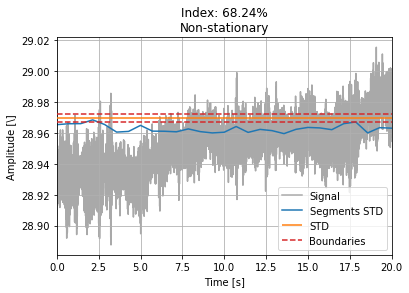

In [24]:
nnst = idns(signal, nsec, sampling_freq, overlap, confidence)
nnst.calc()
nnst.get_index()
nnst.get_limits()[0]
nnst.get_limits()[1]
nnst.get_plot()